### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

#### Loading the data and setting the DateTimeIndex

In [2]:
data = pd.read_csv('../data/time_series_train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [40]:
data_store_1 = data[data['Store']==1]
f = { 'Store': 'first',
      'Weekly_Sales': 'sum',
      'IsHoliday':'first'
    }

data = data_store_1.groupby([data_store_1.index]).agg(f)

#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

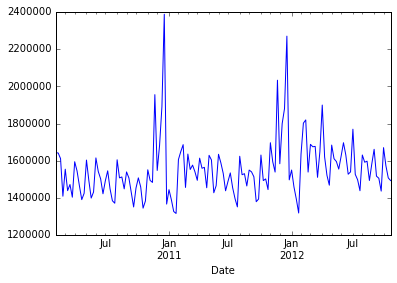

In [52]:
data['Weekly_Sales'].rolling(window=1).mean().plot()

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [51]:
print '1: ',data.Weekly_Sales.diff(1).autocorr(1) #-0.181
print '2: ',data.Weekly_Sales.diff(1).autocorr(2) #-0.181
print '52: ',data.Weekly_Sales.diff(1).autocorr(52) #-0.181

1:  -0.375687265971
2:  -0.0756250144868
52:  0.870656809577


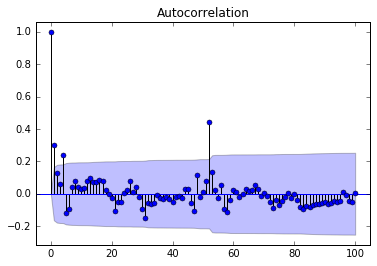

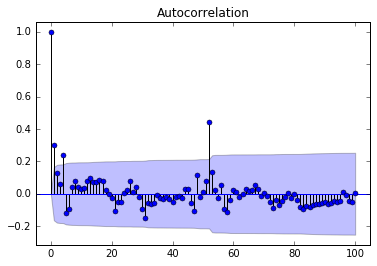

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.Weekly_Sales, lags=100)

#### Split the weekly sales data in a training and test set - using 75% of the data for training.  Remember this is not a typical test/train random split but rather splitting the time series data into chuncks chronologically.

In [53]:
data.shape


(143, 3)

In [57]:
data.sort_index(inplace=True)

In [93]:
cutoff = int(data.shape[0]*.75)

In [69]:
train = data.ix[0:cutoff, : ]
test = data.ix[cutoff:, :]

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [71]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARMA

In [86]:
model = ARMA(train.Weekly_Sales, (1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Thu, 17 Nov 2016   AIC                           2875.327
Time:                        21:22:52   BIC                           2883.345
Sample:                    02-05-2010   HQIC                          2878.577
                         - 02-17-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001         0.133     0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

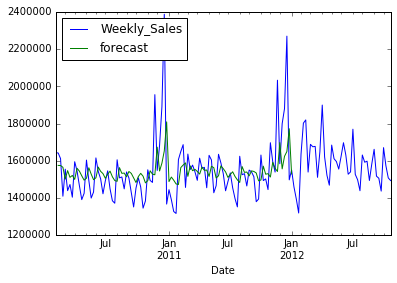

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = data.Weekly_Sales.plot(ax=ax)

fig = model.plot_predict(1, 100, ax=ax, plot_insample=False)

In [88]:
mean_absolute_error(test.Weekly_Sales, model.predict(cutoff,cutoff+35))

81839.338631623992

#### Plot the residuals - where are their significant errors.

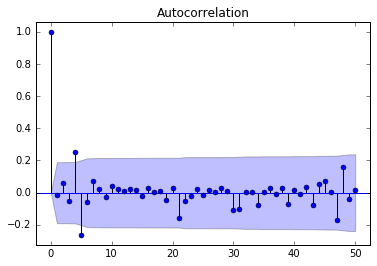

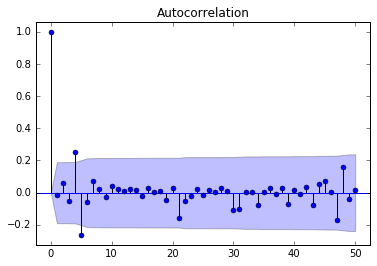

In [89]:
plot_acf(model.resid, lags=50)

In [90]:
# TODO

#### Compute an AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [83]:
model2 = ARMA(train.Weekly_Sales, (2, 2)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144117.204
Date:                Thu, 17 Nov 2016   AIC                           2863.563
Time:                        21:22:12   BIC                           2879.600
Sample:                    02-05-2010   HQIC                          2870.064
                         - 02-17-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.320      0.000      1.51e+06  1.58e+06
ar.L1.Weekly_Sales    -1.0398      0.090    -11.583      0.000        -1.216    -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.380      0.000        -0.641    -0.299
ma.L1.Weekly_Sales     1.4691      0.058     25.341      0.000         1.355     1.583
ma.L2.Weekly_Sales     0.9997      0.074     13.533      0.000         0.855     1.145
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1059           -0.9509j            1.4585           -0.3870
AR.2           -1.1059           +0.9509j            1.4585            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

In [85]:
mean_absolute_error(test.Weekly_Sales, model2.predict(cutoff,cutoff+35))

80502.245756186545

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [91]:
from statsmodels.tsa.arima_model import ARIMA
model3 = ARIMA(train.Weekly_Sales, (7, 1, 1)).fit()
model3.summary()

#plot_acf(model.resid, lags=50)

NameError: name 'ARIMA' is not defined